# Caso Práctico: _Support Vector Machine (SVM)_

## Conjunto de datos: Wine

### Descripción

Vamos a trabajar con los Datasets Wine que ya contiene la libreria sklearn, donde :
- Prepararemos los datos y aplicaremos los distintos algoritmos svm vistos.
- Compararemos resultados. 
- Estos casos es multiclase.
  
Wine recognition dataset
------------------------

**Data Set Characteristics:**

Number of Instances: 178
Number of Attributes: 13 numeric, predictive attributes and the class
Attribute Information:
- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
- Proline
- class

Utilizaremos para ello SVM.

## Imports

In [1]:
%matplotlib inline

import sys
import subprocess

def install_if_missing(packages):
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            print(f"Instalando {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Lista de paquetes necesarios
required_packages = [
    "numpy", "pandas", "matplotlib", "scikit-learn"
]

install_if_missing(required_packages)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.datasets import load_wine
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC, LinearSVC

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

print("Librerías cargadas correctamente.")


Instalando scikit-learn...
Librerías cargadas correctamente.


In [2]:
import warnings
# Ignoramos algunos warnings que se producen por invocar el pipeline sin el nombre de las características
warnings.filterwarnings('ignore', category=UserWarning, message='.*X does not have valid feature names.*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='.*invalid value encountered in subtract.*')

## Funciones auxiliares

In [3]:
def train_val_test_split(df, train_size=0.6, val_size=0.2, rstate=42, shuffle=True, stratify=None):
    """
    Divide un DataFrame en conjuntos de entrenamiento, validación y prueba.

    Parámetros:
    - df (pd.DataFrame): DataFrame a dividir.
    - train_size (float): Proporción del conjunto de entrenamiento (por defecto 60%).
    - val_size (float): Proporción del conjunto de validación (por defecto 20%).
    - rstate (int): Semilla aleatoria para la reproducibilidad (por defecto 42).
    - shuffle (bool): Si se debe mezclar antes de la división (por defecto True).
    - stratify (str): Nombre de la columna usada para estratificación (opcional).

    Retorna:
    - train_set (pd.DataFrame): Conjunto de entrenamiento.
    - val_set (pd.DataFrame): Conjunto de validación.
    - test_set (pd.DataFrame): Conjunto de prueba.
    """
    if stratify and stratify not in df.columns:
        raise ValueError(f"La columna '{stratify}' no existe en el DataFrame.")

    strat = df[stratify] if stratify else None

    train_set, temp_set = train_test_split(
        df, test_size=1 - train_size, random_state=rstate, shuffle=shuffle, stratify=strat
    )

    strat_temp = temp_set[stratify] if stratify else None
    val_ratio = val_size / (1 - train_size)

    val_set, test_set = train_test_split(
        temp_set, test_size=1 - val_ratio, random_state=rstate, shuffle=shuffle, stratify=strat_temp
    )

    return train_set, val_set, test_set


## 1. Lectura del conjunto de datos

Obtendremos el datasets wine desde la librería

In [4]:
# Cargar el dataset
wine = load_wine()

#print(wine.DESCR)

# Convertir a un DataFrame de Pandas
df = pd.DataFrame(wine.data, columns=wine.feature_names)

# Agregar la columna de la clase de vino
df['target'] = wine.target

## 2. Visualización preliminar de la información

In [5]:
df.head(10)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0,0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0,0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0,0
8,14.83,1.64,2.17,14.0,97.0,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045.0,0
9,13.86,1.35,2.27,16.0,98.0,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045.0,0


In [6]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [8]:
df["target"].value_counts()  # Vamos a ver los ejemplos de cada clase.

target
1    71
0    59
2    48
Name: count, dtype: int64

In [9]:
# Comprobación de si existen valores nulos
is_null = df.isna().any()
is_null[is_null]

Series([], dtype: bool)

In [10]:
# Comprobación de la existencia de valores infinitos
is_inf = df.isin([np.inf, -np.inf]).any()
is_inf[is_inf]

Series([], dtype: bool)

In [11]:
correlation_matrix = df.corr()  # Calculamos la matriz de correlación
correlation_with_y = correlation_matrix["target"]  # Obtenemos las correlaciones con la clase 'y+target'

# Mostramos la correlación con la clase
print("Correlación con la clase (target):")
print(correlation_with_y.sort_values(ascending=False))

Correlación con la clase (target):
target                          1.000000
alcalinity_of_ash               0.517859
nonflavanoid_phenols            0.489109
malic_acid                      0.437776
color_intensity                 0.265668
ash                            -0.049643
magnesium                      -0.209179
alcohol                        -0.328222
proanthocyanins                -0.499130
hue                            -0.617369
proline                        -0.633717
total_phenols                  -0.719163
od280/od315_of_diluted_wines   -0.788230
flavanoids                     -0.847498
Name: target, dtype: float64


**Como vemos no tenemos ni nulos ni valores infinitos**

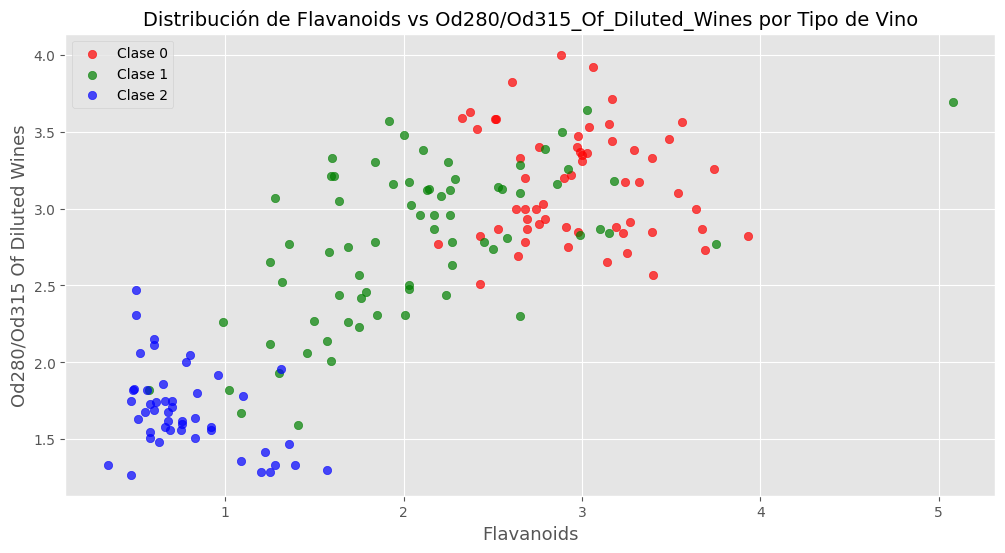

In [12]:
# Seleccionar las dos características más correlaciones con 'target'
top_features = correlation_with_y.abs().sort_values(ascending=False).index[1:3]

# Crear el gráfico
plt.figure(figsize=(12, 6))

# Colores para cada clase de vino
colors = {0: "r", 1: "g", 2: "b"}  # Rojo, Verde, Azul para cada tipo de vino

# Dibujar cada clase de vino con un color diferente
for wine_class in df["target"].unique():
    plt.scatter(df[top_features[0]][df["target"] == wine_class],
                df[top_features[1]][df["target"] == wine_class],
                c=colors[wine_class],
                label=f"Clase {wine_class}",
                alpha=0.7)

# Etiquetas dinámicas según las características seleccionadas
plt.xlabel(top_features[0].replace("_", " ").title(), fontsize=13)
plt.ylabel(top_features[1].replace("_", " ").title(), fontsize=13)
plt.title(f"Distribución de {top_features[0].title()} vs {top_features[1].title()} por Tipo de Vino", fontsize=14)
plt.legend()
plt.show()


## 3. División del conjunto de datos

In [13]:
# División del conjunto de datos
train_set, val_set, test_set = train_val_test_split(df, train_size=0.6, val_size=0.2, stratify="target")


In [14]:
X_train = train_set.drop("target", axis=1)
y_train = train_set["target"].copy()

X_val = val_set.drop("target", axis=1)
y_val = val_set["target"].copy()

X_test = test_set.drop("target", axis=1)
y_test = test_set["target"].copy()

## 4. Preparación del conjunto de datos
Como nuestro datasets no contiene nulos ni infinitos, nuestro datos ya están preparados.

Eso si, debemos escalar nuestro datos datos ya que son muy diferentes (por ejemplo, alcohol está en un rango de 10-15 mientras que proline puede superar los 1000). Para evitar problemas en el modelo debemos normalizar o estandarizar los datos.



In [15]:
class DataFramePreparer(BaseEstimator, TransformerMixin):

    def __init__(self, scaler=None):

        self._scaler = scaler if scaler else StandardScaler()
        self._full_pipeline = None
        self._columns = None

    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']).columns)

        self._full_pipeline = ColumnTransformer([
            ("num", self._scaler, num_attribs)
        ])

        self._full_pipeline.fit(X, y)
        self._columns = num_attribs

        return self

    def transform(self, X, y=None):
        X_prep = self._full_pipeline.transform(X)

        return pd.DataFrame(X_prep, columns=self._columns, index=X.index)


In [16]:
df_preparer = DataFramePreparer()
df_preparer.fit(X_train)

# Transformar los tres conjuntos
X_train_scaled = df_preparer.transform(X_train)
X_val_scaled = df_preparer.transform(X_val)
X_test_scaled = df_preparer.transform(X_test)

# Mostrar las primeras filas del dataset transformado
print("Wine Dataset - Scaled")
print("-" * 50)
X_train_scaled.head()

Wine Dataset - Scaled
--------------------------------------------------


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
33,0.958180,-0.685091,1.240691,0.009033,2.069261,1.081206,0.785036,1.202045,-0.448222,0.124194,1.246969,0.636875,1.526989
85,-0.352751,-1.218988,-0.412659,-0.486231,-0.110942,-0.127907,-0.053179,-0.497979,-0.259070,-1.013785,1.161786,0.874844,-0.970421
31,0.741696,-0.558897,0.018649,-0.123037,0.351525,0.936112,1.256532,-1.177988,0.583515,0.738211,0.565504,0.458399,2.417785
71,1.078449,-0.704505,1.132864,1.825003,-0.969810,1.081206,0.910769,-1.262989,0.445950,-0.702683,1.715477,0.874844,-1.097678
25,0.104271,-0.180316,3.109696,1.825003,1.540727,0.565317,0.722170,0.947041,0.531929,-0.620814,0.735870,0.934336,0.238516


## Funciones generales SVM

In [17]:
def plot_dataset(X, y):
    scatter = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.Pastel1, edgecolors="k", s=40, alpha=0.8)
    cbar = plt.colorbar(scatter)
    cbar.set_ticks([0, 1, 2])
    cbar.set_label("Clase (Target)")

In [18]:
def plot_predictions(clf, X):
    x0_min, x0_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    x1_min, x1_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5

    x0s = np.linspace(x0_min, x0_max, 200)
    x1s = np.linspace(x1_min, x1_max, 200)
    x0, x1 = np.meshgrid(x0s, x1s)

    X_pred = np.c_[x0.ravel(), x1.ravel()]
    X_pred = pd.DataFrame(X_pred, columns=X.columns)

    # Detectar si `clf` es un Pipeline y aplicar la transformación si es necesario**
    if isinstance(clf, Pipeline):
        X_pred = clf[:-1].transform(X_pred)
        y_pred = clf[-1].predict(X_pred)
    else:
        y_pred = clf.predict(X_pred)

    y_pred = y_pred.reshape(x0.shape)

    plt.contourf(x0, x1, y_pred, cmap=plt.cm.Pastel1, alpha=0.3)
    cbar = plt.colorbar()
    cbar.set_ticks([0, 1, 2])
    cbar.set_label("Clase Predicha")
    plt.contour(x0, x1, y_pred, colors="black", linewidths=1.5, alpha=0.7)

In [19]:
def plot_svm_decision_boundary(clf, df, y, title1, title2, top_features):
    # Extraer las características seleccionadas
    X = df[top_features]

    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

    plt.sca(axes[0])
    plot_dataset(X, y)
    plot_predictions(clf, X)
    plt.xlabel(top_features[0].title(), fontsize=11)
    plt.ylabel(top_features[1].title(), fontsize=11)
    plt.title(title1)

    plt.sca(axes[1])
    plot_predictions(clf, X)
    plt.xlabel(top_features[0].title(), fontsize=11)
    plt.ylabel(top_features[1].title(), fontsize=11)
    plt.title(title2)

    plt.show()


In [20]:
def evaluate_svm_model(clf, X_val, y_val):
    y_pred = clf.predict(X_val)
    f1 = f1_score(y_val, y_pred, average="weighted")

    print("="*40)
    print(" 📊  Evaluación del Modelo SVM  📊 ")
    print("="*40)
    print(f"🎯 F1 Score (Weighted): {f1:.4f}")
    print("="*40)

    return f1

## 5. SMV: Kernel lineal

### 5.1 Conjunto de datos reducido

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [21]:
# Seleccionar dos características para la visualización
X_train_reduced = X_train_scaled[top_features].copy()
X_val_reduced = X_val_scaled[top_features].copy()

In [22]:
X_train_reduced

,flavanoids,od280/od315_of_diluted_wines
33,0.785036,0.636875
85,-0.053179,0.874844
31,1.256532,0.458399
71,0.910769,0.874844
25,0.722170,0.934336
...,...,...
126,1.214622,0.398907
170,-1.572445,-1.103272
34,0.565005,0.443526
79,0.585960,0.830225


In [23]:
# Entrenar el modelo SVM con kernel lineal
svm_clfl = SVC(kernel="linear", C=50)  # C alto para un margen más estricto
svm_clfl.fit(X_train_reduced, y_train)

SVC(C=50, kernel='linear')

**Representación del límite de decisión**

In [24]:
def plot_svc_decision_boundary(svm_clf, X, y):
    """
    Representa gráficamente el límite de decisión de un SVM lineal en 2D.

    Parámetros:
    - svm_clf: Modelo SVM ya entrenado.
    - X (DataFrame): Conjunto de datos con 2 características.
    - y (Series): Etiquetas de clase.
    """
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    x0 = np.linspace(x_min, x_max, 200)

    # Cálculo de la frontera de decisión
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    # Cálculo del margen
    margin = 1 / np.linalg.norm(w)
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    # Gráfico de puntos de datos
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k")

    # Dibujar los vectores soporte
    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='none', edgecolors='red', linewidth=2, label="Support Vectors")

    # Dibujar las líneas de decisión y márgenes
    plt.plot(x0, decision_boundary, "k-", linewidth=2, label="Decision Boundary")
    plt.plot(x0, gutter_up, "k--", linewidth=2, label="Margin")
    plt.plot(x0, gutter_down, "k--", linewidth=2)

    # Etiquetas y leyenda
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.title(f"SVM Decision Boundary (C={svm_clf.C})")
    plt.legend()
    plt.show()

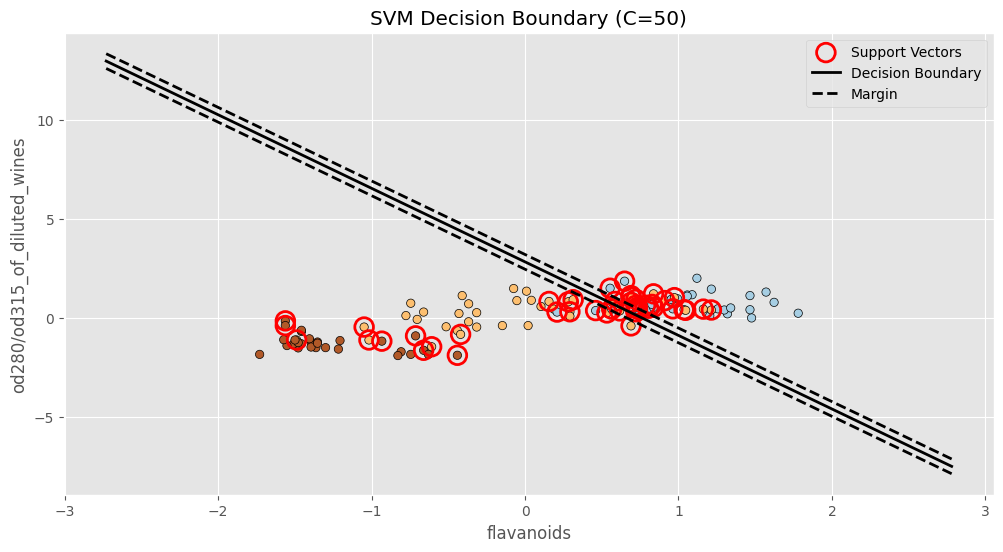

In [25]:
plot_svc_decision_boundary(svm_clfl, X_train_reduced, y_train)

**Predicción con un conjunto de datos reducido**

In [26]:
evaluate_svm_model(svm_clfl, X_val_reduced, y_val)

 📊  Evaluación del Modelo SVM  📊 
🎯 F1 Score (Weighted): 0.9168


0.9167901234567901

### 5.2 Conjunto de datos completo

In [27]:
svm_clfl_whole = SVC(kernel="linear", C=1)
svm_clfl_whole.fit(X_train_scaled, y_train)

SVC(C=1, kernel='linear')

In [28]:
evaluate_svm_model(svm_clfl_whole, X_val_scaled, y_val)

 📊  Evaluación del Modelo SVM  📊 
🎯 F1 Score (Weighted): 0.9443


0.944269005847953

## 6. SMV: Kernel no lineal

### 6.1. Polynomial Kernel (I)

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [29]:
# Seleccionar dos características para la visualización
X_train_reduced = X_train_scaled[top_features].copy()
X_val_reduced = X_val_scaled[top_features].copy()

In [30]:
# Crear el modelo SVM con características polinómicas
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=30, loss="hinge", random_state=42, max_iter=100000, dual=True))
])

# Entrenar el modelo
polynomial_svm_clf.fit(X_train_reduced, y_train)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf',
                 LinearSVC(C=30, dual=True, loss='hinge', max_iter=100000,
                           random_state=42))])

**Representación del límite de decisión**

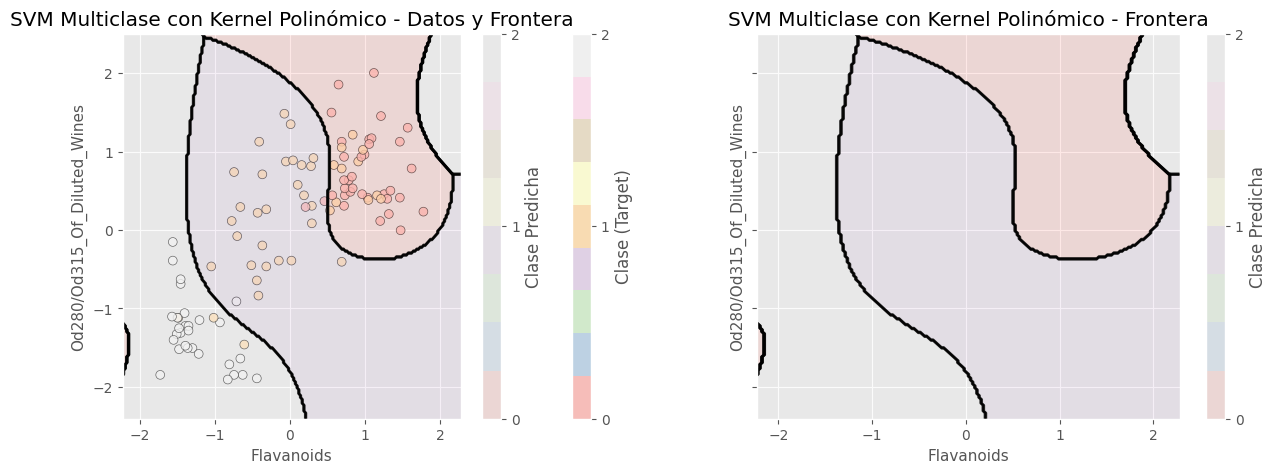

In [31]:
plot_svm_decision_boundary(
    polynomial_svm_clf,
    X_train_reduced,
    y_train,
    "SVM Multiclase con Kernel Polinómico - Datos y Frontera",
    "SVM Multiclase con Kernel Polinómico - Frontera",
    top_features
)

**Predicción con el conjunto de datos reducido**

In [32]:
evaluate_svm_model(polynomial_svm_clf, X_val_reduced, y_val)

 📊  Evaluación del Modelo SVM  📊 
🎯 F1 Score (Weighted): 0.9158


0.9157848324514991

### 6.2. Polynomial Kernel (II)

Existe una forma más sencilla de entrenar un algoritmo SVM que utilize polynomial kernel utilizando el parámetro **kernel** de la propia función implementada en sklearn

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [33]:
#Cambio los hiperparametros para que no de lo mismo en f1score
svm_clfnl = SVC(kernel="poly", degree=3, coef0=20, C=40)
svm_clfnl.fit(X_train_reduced, y_train)

SVC(C=40, coef0=20, kernel='poly')

**Representación del límite de decisión**

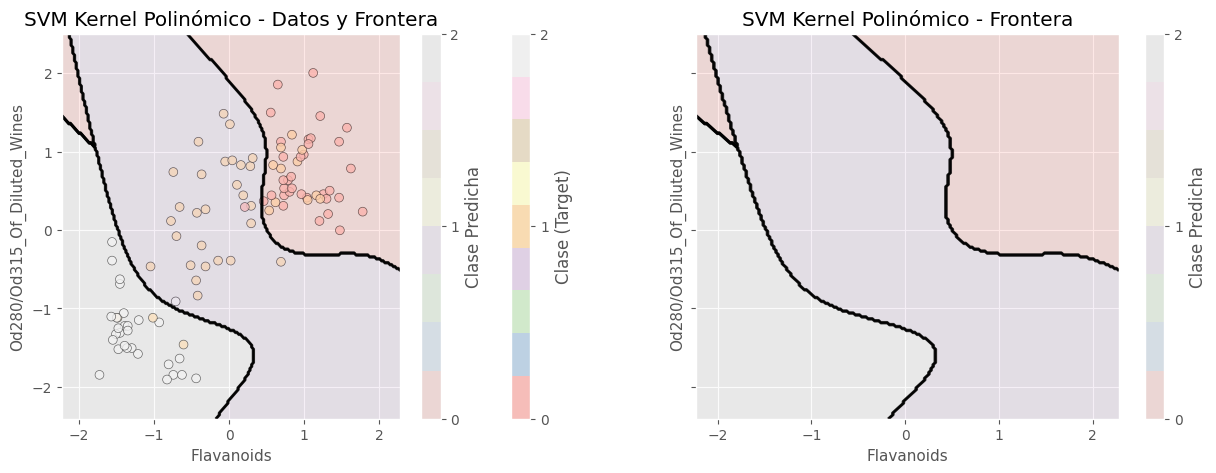

In [34]:
plot_svm_decision_boundary(
    svm_clfnl,
    X_train_reduced,
    y_train,
    "SVM Kernel Polinómico - Datos y Frontera",
    "SVM Kernel Polinómico - Frontera",
    top_features
)


**Predicción con un conjunto de datos reducido**

In [35]:
evaluate_svm_model(svm_clfnl, X_val_reduced, y_val)

 📊  Evaluación del Modelo SVM  📊 
🎯 F1 Score (Weighted): 0.9168


0.9167901234567901

**Predicción con el conjunto de datos completo**

In [36]:
svm_clfnl_whole = SVC(kernel="poly", degree=3, coef0=20, C=40)
svm_clfnl_whole.fit(X_train_scaled, y_train)

SVC(C=40, coef0=20, kernel='poly')

In [37]:
evaluate_svm_model(svm_clfnl_whole, X_val_scaled, y_val)

 📊  Evaluación del Modelo SVM  📊 
🎯 F1 Score (Weighted): 0.9443


0.944269005847953

### 6.2. Gaussian Kernel

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [38]:
# Crear el modelo SVM con kernel RBF y escalado con RobustScaler
rbf_kernel_svm_clf = Pipeline([
    ("scaler", RobustScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=0.5, C=1000))
])

rbf_kernel_svm_clf.fit(X_train_reduced, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('svm_clf', SVC(C=1000, gamma=0.5))])

**Representación del límite de decisión**

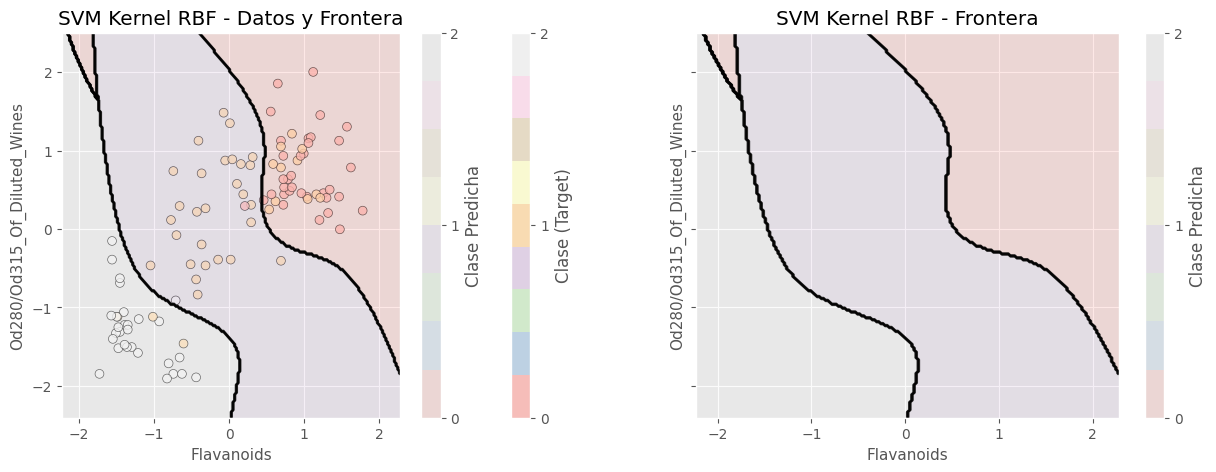

In [39]:
plot_svm_decision_boundary(
    rbf_kernel_svm_clf,
    X_train_reduced,
    y_train,
    "SVM Kernel RBF - Datos y Frontera",
    "SVM Kernel RBF - Frontera",
    top_features
)

**Predicción con un conjunto de datos reducido**

In [40]:
evaluate_svm_model(rbf_kernel_svm_clf, X_val_reduced, y_val)

 📊  Evaluación del Modelo SVM  📊 
🎯 F1 Score (Weighted): 0.9168


0.9167901234567901

**Predicción con un conjunto de datos completo**

In [41]:
rbf_kernel_svm_clf_whole = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.05, C=1000))
        ])

rbf_kernel_svm_clf_whole.fit(X_train_scaled, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('svm_clf', SVC(C=1000, gamma=0.05))])

In [42]:
evaluate_svm_model(rbf_kernel_svm_clf_whole, X_val_scaled, y_val)

 📊  Evaluación del Modelo SVM  📊 
🎯 F1 Score (Weighted): 0.9720


0.9719701552732407

### Comparaciont de todos los modelos

In [43]:
print("="*50)
print(" 📊  Comparación de Modelos SVM  📊 ")
print("="*50)

print("\n🔹 **SVM Lineal con Datos Reducidos**")
print(f"   🎯 F1 Score: {f1_score(y_val, svm_clfl.predict(X_val_reduced), average='weighted'):.4f}")

print("\n🔹 **SVM Lineal con Todas las Características**")
print(f"   🎯 F1 Score: {f1_score(y_val, svm_clfl_whole.predict(X_val_scaled), average='weighted'):.4f}")

print("\n🔹 **SVM Polinómico con Datos Reducidos**")
print(f"   🎯 F1 Score: {f1_score(y_val, polynomial_svm_clf.predict(X_val_reduced), average='weighted'):.4f}")

print("\n🔹 **SVM Polinómico con Todas las Características**")
print(f"   🎯 F1 Score: {f1_score(y_val, svm_clfnl_whole.predict(X_val_scaled), average='weighted'):.4f}")

print("\n🔹 **SVM Kernel RBF con Datos Reducidos**")
print(f"   🎯 F1 Score: {f1_score(y_val, rbf_kernel_svm_clf.predict(X_val_reduced), average='weighted'):.4f}")

print("\n🔹 **SVM Kernel RBF con Todas las Características**")
print(f"   🎯 F1 Score: {f1_score(y_val, rbf_kernel_svm_clf_whole.predict(X_val_scaled), average='weighted'):.4f}")

print("="*50)


 📊  Comparación de Modelos SVM  📊 

🔹 **SVM Lineal con Datos Reducidos**
   🎯 F1 Score: 0.9168

🔹 **SVM Lineal con Todas las Características**
   🎯 F1 Score: 0.9443

🔹 **SVM Polinómico con Datos Reducidos**
   🎯 F1 Score: 0.9158

🔹 **SVM Polinómico con Todas las Características**
   🎯 F1 Score: 0.9443

🔹 **SVM Kernel RBF con Datos Reducidos**
   🎯 F1 Score: 0.9168

🔹 **SVM Kernel RBF con Todas las Características**
   🎯 F1 Score: 0.9720
